In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import ast
import numpy as np


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import cohen_kappa_score

In [ ]:
def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
file_path = 'gdrive/My Drive/Preferences/data_500_2.csv' #second dataset has more randomness

Mounted at /content/gdrive


In [ ]:
#df = pd.read_csv(file_path)
df = pd.read_csv(file_path, converters={'Calendar': from_np_array})

In [ ]:
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
def convert(array):
  out = []
  for list in array:
    # Converting integer list to string list
    s = [str(int(i)) for i in list]
    # Join list items using join()
    res = "".join(s)
    out.append(res)

      
  return(out)

In [ ]:
df['string'] =  df.apply(lambda x: str(x['Calendar']), axis=1)
df['lbl_concat'] =  df.apply(lambda x: x['lbl_concat']-1, axis=1)
df['cal_flat'] =  df.apply(lambda x: x['Calendar'].flatten(), axis=1)

In [ ]:
columns = ['Week','Day','b2b','lbl_concat']
df_copy = df.copy()
df_lookup = df_copy[columns].head(18)

In [ ]:
df_lookup = df_lookup.replace(np.nan, 'None')


In [ ]:
df_lookup

,Week,Day,b2b,lbl_concat
0,early,early,True,0
1,early,early,False,1
2,early,late,True,2
3,early,late,False,3
4,early,None,True,4
5,early,None,False,5
6,late,early,True,6
7,late,early,False,7
8,late,late,True,8
9,late,late,False,9


In [ ]:
# df_lookup.to_csv('lookup.csv')
# !cp lookup.csv "gdrive/My Drive/Preferences"

In [ ]:
print('Sum of duplicates:')
print(df.string.duplicated().sum())

Sum of duplicates:
0


In [ ]:
df = df.drop_duplicates(subset=['string'])

In [ ]:
df.string.duplicated().sum()

0

In [ ]:
counts = []
for i in range(18):
  counts.append(df[df['lbl_concat']==i+1]['Calendar'].count())

In [ ]:
#shuffle dataset
df = df.sample(frac=1)

In [ ]:
 df['String_cal'] = df.apply(lambda x: convert(x['Calendar']), axis=1)

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1)

In [ ]:
counts_train = []
counts_test = []
for i in range(18):
  counts_train.append(train_df[train_df['lbl_concat']==i+1]['Calendar'].count())
  counts_test.append(test_df[test_df['lbl_concat']==i+1]['Calendar'].count())


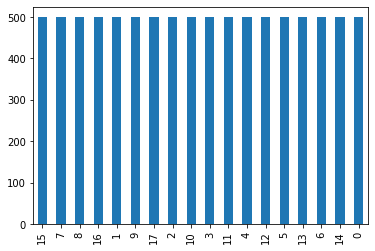

In [ ]:
df['lbl_concat'].value_counts().plot(kind='bar')


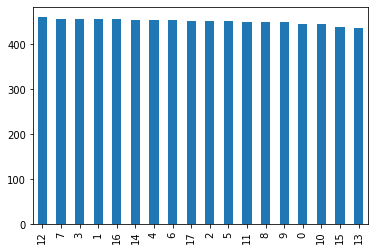

In [ ]:
train_df['lbl_concat'].value_counts().plot(kind='bar')

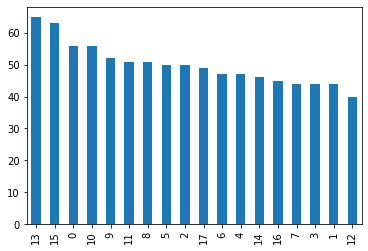

In [ ]:
test_df['lbl_concat'].value_counts().plot(kind='bar')

In [ ]:
df = df.drop(columns=['string'])

In [ ]:
x_train = train_df['cal_flat']
y_train = train_df['lbl_concat']

x_test = test_df['cal_flat']
y_test = test_df['lbl_concat']

In [ ]:
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()

x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

In [ ]:
xtrain = torch.FloatTensor(x_train_np.tolist())
ytrain = torch.FloatTensor(y_train_np.tolist())

xtest = torch.FloatTensor(x_test_np.tolist())
ytest = torch.FloatTensor(y_test_np.tolist())

In [ ]:
# hyperparameters
input_size = 168 #7x24
output_size = 18 #0-17 (classes)
hidden_size = 100

epochs = 500
batch_size = 32
learning_rate = 0.001
dropout_rate = 0.3

In [ ]:
#https://www.kaggle.com/justuser/mnist-with-pytorch-fully-connected-network
class FCNN(nn.Module):
    
    def __init__(self):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size//2)
        self.fc3 = nn.Linear(hidden_size//2, hidden_size//4)
        self.fc4 = nn.Linear(hidden_size//4, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        
        # self.dropout1 = nn.Dropout(0.2)
        # self.dropout2 = nn.Dropout(0.8)

        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

In [ ]:
model = FCNN()
print(model)

FCNN(
  (fc1): Linear(in_features=168, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=25, bias=True)
  (fc4): Linear(in_features=25, out_features=18, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
xtrain.shape
y_train.shape

(8100,)

In [ ]:
def get_acc(y_pred, actual):
  denom = y_pred.shape[0]
  out = np.sum(y_pred == actual)/denom*100
  return out

In [ ]:
loss_log = []
train_acc = []

loss_avg_lst = []
acc_avg_lst = []
add_every = 500

#per epoch
for epoch in range(epochs):
  loss_total = 0
  acc_total = 0
  step = 0
  #per item in batch:

  for i in range(0, xtrain.shape[0], batch_size):

    step+=1
    x_batch = xtrain[i:i + batch_size] 
    y_batch = ytrain[i:i + batch_size] 
    x_var = Variable(x_batch)
    y_var = Variable(y_batch).type(torch.LongTensor)
    optimizer.zero_grad()
    net_out = model(x_var)
    y_pred = torch.max(net_out.data, 1)[1].numpy()
    actual = y_batch.numpy()
    accuracy = get_acc(y_pred, actual)
    loss = criterion(net_out, y_var)

    loss_total += loss.item()
    acc_total += accuracy

    loss.backward()
    optimizer.step()

    if i % add_every == 0:
      loss_log.append(loss.item())
      train_acc.append(accuracy)
    

  acc_avg = acc_total/step
  loss_avg = loss_total/step

  loss_avg_lst.append(loss_avg)
  acc_avg_lst.append(acc_avg)



  print('Epoch: {}/{} | Train Loss: {:.4f} | Train Acc: {:.2f} '.format(epoch, epochs, loss_avg, acc_avg))


Epoch: 0/500 | Train Loss: 2.8940 | Train Acc: 5.81 
Epoch: 1/500 | Train Loss: 2.8906 | Train Acc: 6.00 
Epoch: 2/500 | Train Loss: 2.8866 | Train Acc: 6.85 
Epoch: 3/500 | Train Loss: 2.8817 | Train Acc: 7.44 
Epoch: 4/500 | Train Loss: 2.8743 | Train Acc: 8.61 
Epoch: 5/500 | Train Loss: 2.8596 | Train Acc: 10.78 
Epoch: 6/500 | Train Loss: 2.8309 | Train Acc: 12.07 
Epoch: 7/500 | Train Loss: 2.7607 | Train Acc: 12.62 
Epoch: 8/500 | Train Loss: 2.6268 | Train Acc: 12.14 
Epoch: 9/500 | Train Loss: 2.4594 | Train Acc: 13.57 
Epoch: 10/500 | Train Loss: 2.3381 | Train Acc: 14.09 
Epoch: 11/500 | Train Loss: 2.2634 | Train Acc: 15.83 
Epoch: 12/500 | Train Loss: 2.1865 | Train Acc: 17.86 
Epoch: 13/500 | Train Loss: 2.1108 | Train Acc: 19.16 
Epoch: 14/500 | Train Loss: 2.0303 | Train Acc: 22.40 
Epoch: 15/500 | Train Loss: 1.9695 | Train Acc: 24.22 
Epoch: 16/500 | Train Loss: 1.8737 | Train Acc: 28.01 
Epoch: 17/500 | Train Loss: 1.7661 | Train Acc: 31.90 
Epoch: 18/500 | Train Los

In [ ]:
#torch.save(model.state_dict(), 'gdrive/My Drive/Preferences/FCCN_model_2.pth' )

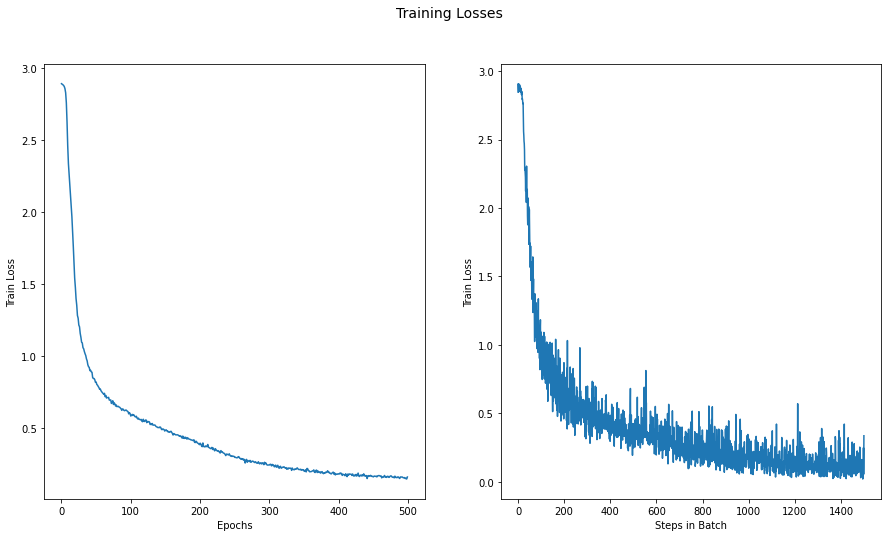

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
fig.suptitle("Training Losses", fontsize=14)
axes[0].plot(loss_avg_lst)
axes[1].plot(loss_log)
axes[0].set(xlabel="Epochs", ylabel="Train Loss")
axes[1].set(xlabel="Steps in Batch", ylabel="Train Loss")
plt.savefig("gdrive/My Drive/Preferences/pref_losses.png")
plt.show()
#fig.tight_layout()

# plt.figure(figsize=(10,8))
# plt.plot(loss_avg_lst)

# plt.figure(figsize=(10,8))
# plt.plot(loss_log)

[Text(0, 0.5, 'Train Accuracy'), Text(0.5, 0, 'Steps in Batch')]

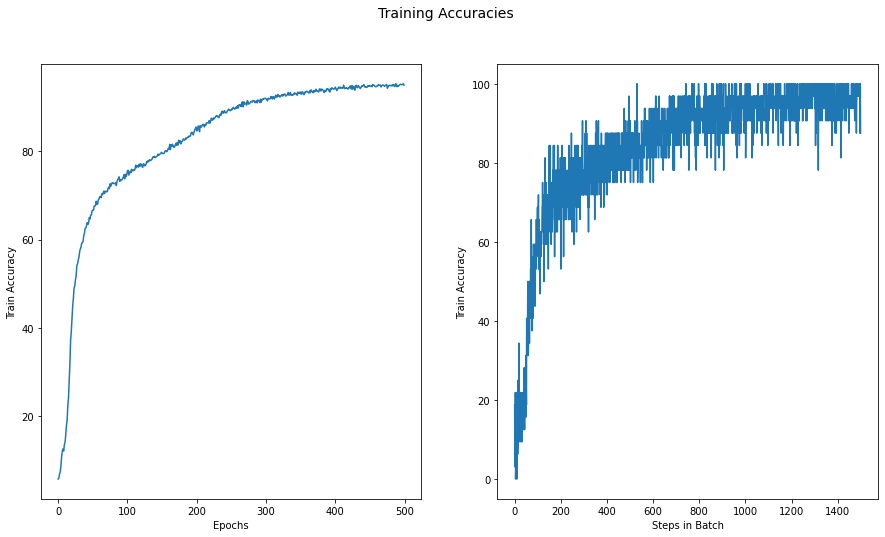

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
fig = plt.gcf()
fig.suptitle("Training Accuracies", fontsize=14)
axes[0].plot(acc_avg_lst)
axes[1].plot(train_acc)
axes[0].set(xlabel="Epochs", ylabel="Train Accuracy")
axes[1].set(xlabel="Steps in Batch", ylabel="Train Accuracy")
# plt.savefig("gdrive/My Drive/Preferences/pref_accuracies.png")
# plt.show()
#fig.tight_layout()

# plt.figure(figsize=(10,8))
# plt.plot(acc_avg_lst)

# plt.figure(figsize=(10,8))
# plt.plot(train_acc)

In [ ]:
model.eval()
with torch.no_grad():
  test_var = Variable(xtest)

  net_out = model(test_var)
  test_pred = torch.max(net_out.data, 1)[1].numpy()
  test_acc = get_acc(test_pred, y_test)
print(100*'-')
print('Test Accuracy:', test_acc)
print(100*'-')

----------------------------------------------------------------------------------------------------
Test Accuracy: 94.11111111111111
----------------------------------------------------------------------------------------------------


In [ ]:
actual = y_test.tolist() 
predicted = test_pred
target_names = list(range(18))
conf_mat = confusion_matrix(actual, predicted, target_names)   
target_names = ['class 0', 'class 1', 'class 2']
print('Confusion Matrix :')
print(conf_mat) 
acc = accuracy_score(actual, predicted)
print ('Accuracy: %.3f'% acc) 
print(100*'-')
print()
print ('Classification report : ')
print (classification_report(actual, predicted, digits=3) )
print(100*'-')
f_score = f1_score(actual, predicted, average = None )

Confusion Matrix :
[[56  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 47  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  3 43  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 47  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 43  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 51  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 52  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 55  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  3  0  0  1 47  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 40  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1 47  0  0  0 17]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 46  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 62  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0 44  0]
 [ 0  0  0  

[Text(0, 0.5, '0'),
 Text(0, 1.5, '1'),
 Text(0, 2.5, '2'),
 Text(0, 3.5, '3'),
 Text(0, 4.5, '4'),
 Text(0, 5.5, '5'),
 Text(0, 6.5, '6'),
 Text(0, 7.5, '7'),
 Text(0, 8.5, '8'),
 Text(0, 9.5, '9'),
 Text(0, 10.5, '10'),
 Text(0, 11.5, '11'),
 Text(0, 12.5, '12'),
 Text(0, 13.5, '13'),
 Text(0, 14.5, '14'),
 Text(0, 15.5, '15'),
 Text(0, 16.5, '16'),
 Text(0, 17.5, '17')]

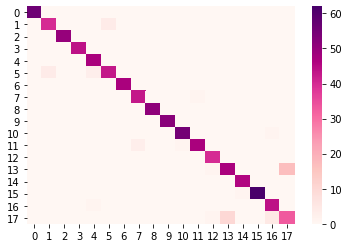

In [ ]:
ax= plt.subplot()
counts = ["{0:0.0f}".format(i) for i in conf_mat.flatten()]
percentages = ["{0:.2%}".format(i) for i in conf_mat.flatten()/np.sum(conf_mat)]
sns.heatmap(conf_mat, fmt='', cmap= 'RdPu')
ax.xaxis.set_ticklabels(list(range(18)))
ax.yaxis.set_ticklabels(list(range(18)))
# plt.savefig("gdrive/My Drive/Preferences/pref_conf_mat.png")
# plt.show()

In [ ]:
report = classification_report(actual, predicted, digits=3, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,56.000000
1,0.909091,0.909091,0.909091,44.000000
2,1.000000,1.000000,1.000000,50.000000
3,1.000000,1.000000,1.000000,44.000000
4,0.921569,1.000000,0.959184,47.000000
5,0.914894,0.860000,0.886598,50.000000
6,1.000000,1.000000,1.000000,47.000000
7,0.934783,0.977273,0.955556,44.000000
8,1.000000,1.000000,1.000000,51.000000
9,1.000000,1.000000,1.000000,52.000000


In [ ]:
print(report_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &     support \\
\midrule
0            &   1.000000 &  1.000000 &  1.000000 &   56.000000 \\
1            &   0.909091 &  0.909091 &  0.909091 &   44.000000 \\
2            &   1.000000 &  1.000000 &  1.000000 &   50.000000 \\
3            &   1.000000 &  1.000000 &  1.000000 &   44.000000 \\
4            &   0.921569 &  1.000000 &  0.959184 &   47.000000 \\
5            &   0.914894 &  0.860000 &  0.886598 &   50.000000 \\
6            &   1.000000 &  1.000000 &  1.000000 &   47.000000 \\
7            &   0.934783 &  0.977273 &  0.955556 &   44.000000 \\
8            &   1.000000 &  1.000000 &  1.000000 &   51.000000 \\
9            &   1.000000 &  1.000000 &  1.000000 &   52.000000 \\
10           &   0.982143 &  0.982143 &  0.982143 &   56.000000 \\
11           &   0.979167 &  0.921569 &  0.949495 &   51.000000 \\
12           &   0.952381 &  1.000000 &  0.975610 &   40.000000 \\
13           &   0.824561 &  0.

In [ ]:
test_array_1 = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
test_array_2 = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])#


In [ ]:
test_array_2.flatten()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
test_array_3= np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
test_array_4 = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])#

In [ ]:
test_array_5 = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
test_array_6 = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
        0., 1., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
test_array_7 = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
        0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0.,
        0., 1., 1., 1., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0.,
        0., 1., 1., 1., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
def predict_preference(in_model, in_array, lookup, print_on):

  test_sample = torch.FloatTensor(in_array.flatten().tolist())
  in_model.eval()
  with torch.no_grad():
    test_var = Variable(test_sample)
    test_var = test_var.unsqueeze(1).T

    net_out = in_model(test_var)
    test_pred = torch.max(net_out.data, 1)[1].numpy()
    predicted_label = test_pred.item()
    if print_on:
      lookup_row = lookup[lookup['lbl_concat'] == predicted_label]
      w = lookup_row['Week'].item()
      d = lookup_row['Day'].item()
      b = lookup_row['b2b'].item()

      print(100*'-')
      print('Predictions:')
      print(100*'-')
      print()
      print('Predicted Label:',predicted_label)
      print('Time of week preference:', w)
      print('Time of day preference:', d)
      print('Back to back meetings (True/False):', b)
      print()
      print(100*'-')
      print()
      print(100*'-')
      plt.imshow(in_array)
      plt.yticks(ticks = list(range(7)), labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
      plt.xticks(ticks = list(range(24)),labels =  list(range(24)))
      plt.xlabel('Timeslot')
      plt.ylabel('Week Index')
    return test_pred.item()

----------------------------------------------------------------------------------------------------
Predictions:
----------------------------------------------------------------------------------------------------

Predicted Label: 0
Time of week preference: early
Time of day preference: early
Back to back meetings (True/False): True

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------


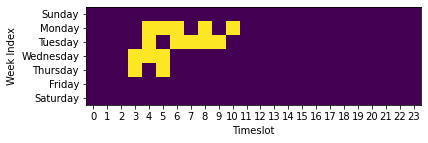

In [ ]:
predicted_label = predict_preference(model, test_array_2, df_lookup, True)
plt.savefig("gdrive/My Drive/Preferences/0.png")
plt.show()

----------------------------------------------------------------------------------------------------
Predictions:
----------------------------------------------------------------------------------------------------

Predicted Label: 3
Time of week preference: early
Time of day preference: late
Back to back meetings (True/False): False

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------


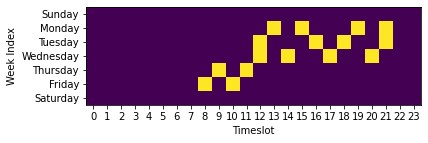

In [ ]:
predicted_label = predict_preference(model, test_array_1, df_lookup, True)
plt.savefig("gdrive/My Drive/Preferences/3.png")
plt.show()

----------------------------------------------------------------------------------------------------
Predictions:
----------------------------------------------------------------------------------------------------

Predicted Label: 4
Time of week preference: early
Time of day preference: None
Back to back meetings (True/False): True

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------


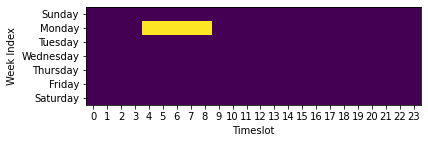

In [ ]:
predicted_label = predict_preference(model, test_array_4, df_lookup, True)
plt.savefig("gdrive/My Drive/Preferences/4.png")
plt.show()

----------------------------------------------------------------------------------------------------
Predictions:
----------------------------------------------------------------------------------------------------

Predicted Label: 5
Time of week preference: early
Time of day preference: None
Back to back meetings (True/False): False

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------


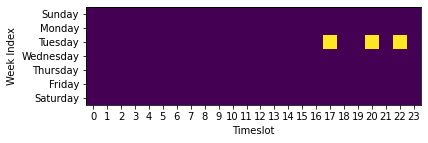

In [ ]:
predicted_label = predict_preference(model, test_array_5, df_lookup, True)
plt.savefig("gdrive/My Drive/Preferences/5.png")
plt.show()

----------------------------------------------------------------------------------------------------
Predictions:
----------------------------------------------------------------------------------------------------

Predicted Label: 15
Time of week preference: None
Time of day preference: late
Back to back meetings (True/False): False

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------


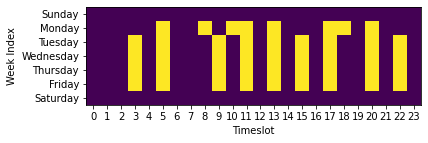

In [ ]:
predicted_label = predict_preference(model, test_array_6, df_lookup, True)

----------------------------------------------------------------------------------------------------
Predictions:
----------------------------------------------------------------------------------------------------

Predicted Label: 3
Time of week preference: early
Time of day preference: late
Back to back meetings (True/False): False

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------


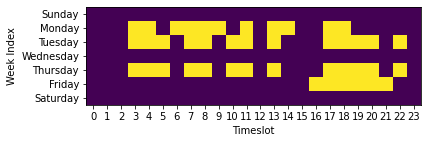

In [ ]:
predicted_label = predict_preference(model, test_array_7, df_lookup, True)

In [ ]:
print(df_lookup.to_latex())

\begin{tabular}{llllr}
\toprule
{} &   Week &    Day &    b2b &  lbl\_concat \\
\midrule
0  &  early &  early &   True &           0 \\
1  &  early &  early &  False &           1 \\
2  &  early &   late &   True &           2 \\
3  &  early &   late &  False &           3 \\
4  &  early &   None &   True &           4 \\
5  &  early &   None &  False &           5 \\
6  &   late &  early &   True &           6 \\
7  &   late &  early &  False &           7 \\
8  &   late &   late &   True &           8 \\
9  &   late &   late &  False &           9 \\
10 &   late &   None &   True &          10 \\
11 &   late &   None &  False &          11 \\
12 &   None &  early &   True &          12 \\
13 &   None &  early &  False &          13 \\
14 &   None &   late &   True &          14 \\
15 &   None &   late &  False &          15 \\
16 &   None &   None &   True &          16 \\
17 &   None &   None &  False &          17 \\
\bottomrule
\end{tabular}

